# 5. Runtime Analysis

In [16]:
import numpy as np
import time
import pandas as pd
import seaborn as sns
from dtw_algorithm import get_accum_cost_and_steps, get_path

# Conduct runtime experiments

In [2]:
def get_settings(algorithm):

    steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
    weights = np.array([2,3,3])
    warp_max, subsequence = None, False

    if algorithm == 'DTW2':
        steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
        weights = np.array([1,2,2])
    elif algorithm == 'DTW3':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights = np.array([1,1,2])
    elif algorithm == 'DTW4':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights = np.array([1,1,1])
    elif algorithm == 'DTW5':
        steps = np.array([0,1,1,0]).reshape((-1,2))
        weights = np.array([1,1])
    elif algorithm == 'DTW1_add3':
        steps = np.array([1,1,1,2,2,1,1,3,3,1]).reshape((-1,2))
        weights = np.array([2,3,3,4,4])
    elif algorithm == 'DTW1_add4':
        steps = np.array([1,1,1,2,2,1,1,3,3,1,1,4,4,1]).reshape((-1,2))
        weights = np.array([2,3,3,4,4,5,5])

    elif algorithm == 'adaptiveWeight1':
        steps = np.array([0,1,1,0]).reshape((-1,2))
    elif algorithm == 'adaptiveWeight2':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))

    elif algorithm == 'selectiveTransitions2':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights, warp_max = np.array([1,1,2]), 2
    elif algorithm == 'selectiveTransitions3':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights, warp_max = np.array([1,1,2]), 3
    elif algorithm == 'selectiveTransitions4':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights, warp_max = np.array([1,1,2]), 4
    elif algorithm == 'selectiveTransitions5':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights, warp_max = np.array([1,1,2]), 5

    elif algorithm == 'SubDTW1':
        steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
        weights, subsequence = np.array([1,1,2]), True
    elif algorithm == 'SubDTW2':
        steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
        weights, subsequence = np.array([2,3,3]), True
    elif algorithm == 'SubDTW3':
        steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
        weights, subsequence = np.array([1,2,2]), True
    elif algorithm == 'SubDTW4':
        steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
        weights, subsequence = np.array([1,1,1]), True
    elif algorithm == 'SubDTW5':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights, subsequence = np.array([0,1,1]), True
    elif algorithm == 'SubDTW6':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights, subsequence = np.array([1,1,1]), True
    elif algorithm == 'SubDTW7':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights, subsequence = np.array([1,1,2]), True

    elif algorithm == 'SubDTW3_add3':
        steps = np.array([1,1,1,2,2,1,1,3,3,1]).reshape((-1,2))
        weights, subsequence = np.array([1,2,2,1,3]), True
    elif algorithm == 'SubDTW6_add3':
        steps = np.array([0,1,1,0,1,1,1,3,3,1]).reshape((-1,2))
        weights, subsequence = np.array([1,1,1,1,3]), True
    elif algorithm == 'SubDTW3_add4':
        steps = np.array([1,1,1,2,2,1,1,3,3,1,1,4,4,1]).reshape((-1,2))
        weights, subsequence = np.array([1,2,2,1,3,1,4]), True
    elif algorithm == 'SubDTW6_add4':
        steps = np.array([0,1,1,0,1,1,1,3,3,1,1,4,4,1]).reshape((-1,2))
        weights, subsequence = np.array([1,1,1,1,3,1,4]), True

    elif algorithm == 'SubDTW_selectiveTransitions2':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights = np.array([1,1,2])
        warp_max, subsequence = 2, True
    elif algorithm == 'SubDTW_selectiveTransitions3':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights = np.array([1,1,2])
        warp_max, subsequence = 3, True
    elif algorithm == 'SubDTW_selectiveTransitions4':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights = np.array([1,1,2])
        warp_max, subsequence = 4, True
    elif algorithm == 'SubDTW_selectiveTransitions5':
        steps = np.array([0,1,1,0,1,1]).reshape((-1,2))
        weights = np.array([1,1,2])
        warp_max, subsequence = 5, True

    return steps, weights, warp_max, subsequence

In [3]:
def alignDTW(F1, F2, algorithm):

    res = []
    steps, weights, warp_max, subsequence = get_settings(algorithm)
    N, M = F1.shape[1], F2.shape[1] # we assume that N >= M
    res.append(time.time())
    
    # apply downsampling or adaptive weights
    if algorithm == "downsampleQuantized":
        # we wish to only select M columns of of F1 to get (12 x M)
        index = [int(round(x)) for x in np.linspace(0, N-1, M)]
        F1 = F1[:, index]
    elif algorithm == "downsampleInterpolate":
        # we want to multiply matrix (12 x N) by (N x M) to get (12 x M)
        transform = np.zeros((N, M))
        index = np.linspace(0, N-1, M) # M indices evenly spaced between [0, N-1]
        for col, index in enumerate(index):
            # at column m, insert weight RIGHT at position ROW and LEFT at position ROW+1
            row = int(index)
            right = index - int(index)
            left = 1 - right
            # if we are at the last row, insert weight 1
            if row + 1 == N:
                transform[row, col] = 1
                continue
            transform[row, col] = left
            transform[row+1, col] = right
        F1 = F1 @ transform
    elif algorithm == "upsampleQuantized":
        index = [int(x) for x in np.linspace(0, M-1, N)]
        F2 = F2[:, index] 
    elif algorithm == "upsampleInterpolate":
        # we want to multiply matrix (12 x M) by (M x N) to get (12 x N)
        transform = np.zeros((M, N))
        index = np.linspace(0, M-1, N) # N indices evenly spaced between [0, M-1]
        for col, index in enumerate(index):
            # at column N, insert weight RIGHT at position ROW and LEFT at position ROW+1
            row = int(index)
            right = index - int(index)
            left = 1 - right
            # if we are at the last row, insert weight 1
            if row + 1 == M:
                transform[row, col] = 1
                continue
            transform[row, col] = left
            transform[row+1, col] = right
        F2 = F2 @ transform
    elif algorithm == "adaptiveWeight1":
        weights = np.array([N/M, 1])
    elif algorithm == "adaptiveWeight2":
        weights = np.array([N/M, 1, 1 + N/M])
    res.append(time.time())

    # compute cost matrix
    C = 1 - F1.T @ F2
    res.append(time.time())

    # run DTW algorithm
    x_steps = steps[:,0].astype(np.uint32) # horizontal steps
    y_steps = steps[:,1].astype(np.uint32) # veritcal steps
    params = {'x_steps': x_steps, 'y_steps': y_steps, 'weights': weights, 'subsequence': subsequence}
    D, s = get_accum_cost_and_steps(C, params, warp_max)
    res.append(time.time())

    # retrieve paths and steps taken
    path, _, _, track_steps = get_path(D, s, params)
    res.append(time.time())

    if algorithm == "downsampleQuantized" or algorithm == "downsampleInterpolate":
        path[0] = path[0] * N / M
    elif algorithm == "upsampleQuantized" or algorithm == "upsampleInterpolate":
        path[1] = path[1] * M / N
    res.append(time.time())
    
    return np.diff(res)

In [ ]:
algos = ['DTW1', 'DTW2', 'DTW3', 'DTW4', 'DTW5', 'DTW1_add3', 'DTW1_add4', 'downsampleQuantized', 'downsampleInterpolate', 'upsampleQuantized', 'upsampleInterpolate', 'adaptiveWeight1', 'adaptiveWeight2', 'selectiveTransitions2','selectiveTransitions3','selectiveTransitions4','selectiveTransitions5']
Ns = [100, 300, 1_000, 3_000, 10_000, 30_000]
Ks = [1, 2, 4]

with open('run_time.csv', 'w') as f:
    for algo in algos:
        for N in Ns:
            for K in Ks:
                for _ in range(10):

                    F1 = np.random.rand(12,N)
                    F2 = np.random.rand(12,N*K)
                    times = alignDTW(F1, F2, algo)
                    times = ",".join(map(str, times))
                    f.write(f'{algo},{N},{N*K},{times}\n')

# Perform analysis

In [51]:
df =  pd.read_csv('run_time.csv')
for i in range(3,df.shape[1]):
    df.iloc[:,i] = df.iloc[:,i].apply(lambda x: float(x))
df['total'] = df["adjust_sample_adaptive"] + df["compute_cost_matrix"] + df["get_accum_cost_and_steps"] + df["retrieve_path"] + df["adjust_sample"]
df = df.drop(["adjust_sample_adaptive", "compute_cost_matrix", "get_accum_cost_and_steps", "retrieve_path", "adjust_sample"], axis=1)

mean = df.groupby(["algorithm", "N", "M"]).mean().reset_index()
mean['size'] =  mean['N'].astype(str) + " x " + mean['M'].astype(str)
mean.drop(["N", "M"], axis = 1, inplace=True)
mean = mean.pivot(index="size", columns="algorithm", values="total")
index = list(mean.index)
index.sort(key = lambda x: int(x.split(" x ")[0]) + int(x.split(" x ")[1]))
mean = mean.reindex(index)
# mean = np.log(mean)
mean = round(mean, 6)
mean = mean[['DTW1', 'DTW2', 'DTW3', 'DTW4', 'DTW5', 'DTW1_add3', 'DTW1_add4', 'DTW2_downsampleQuantized', 'DTW2_downsampleInterpolate', 'DTW2_upsampleQuantized', 'DTW2_upsampleInterpolate', 'adaptiveWeight1', 'adaptiveWeight2', 'selectiveTransitions2','selectiveTransitions3','selectiveTransitions4','selectiveTransitions5']]

Text(0.5, 1.0, 'Average across 10 runs')

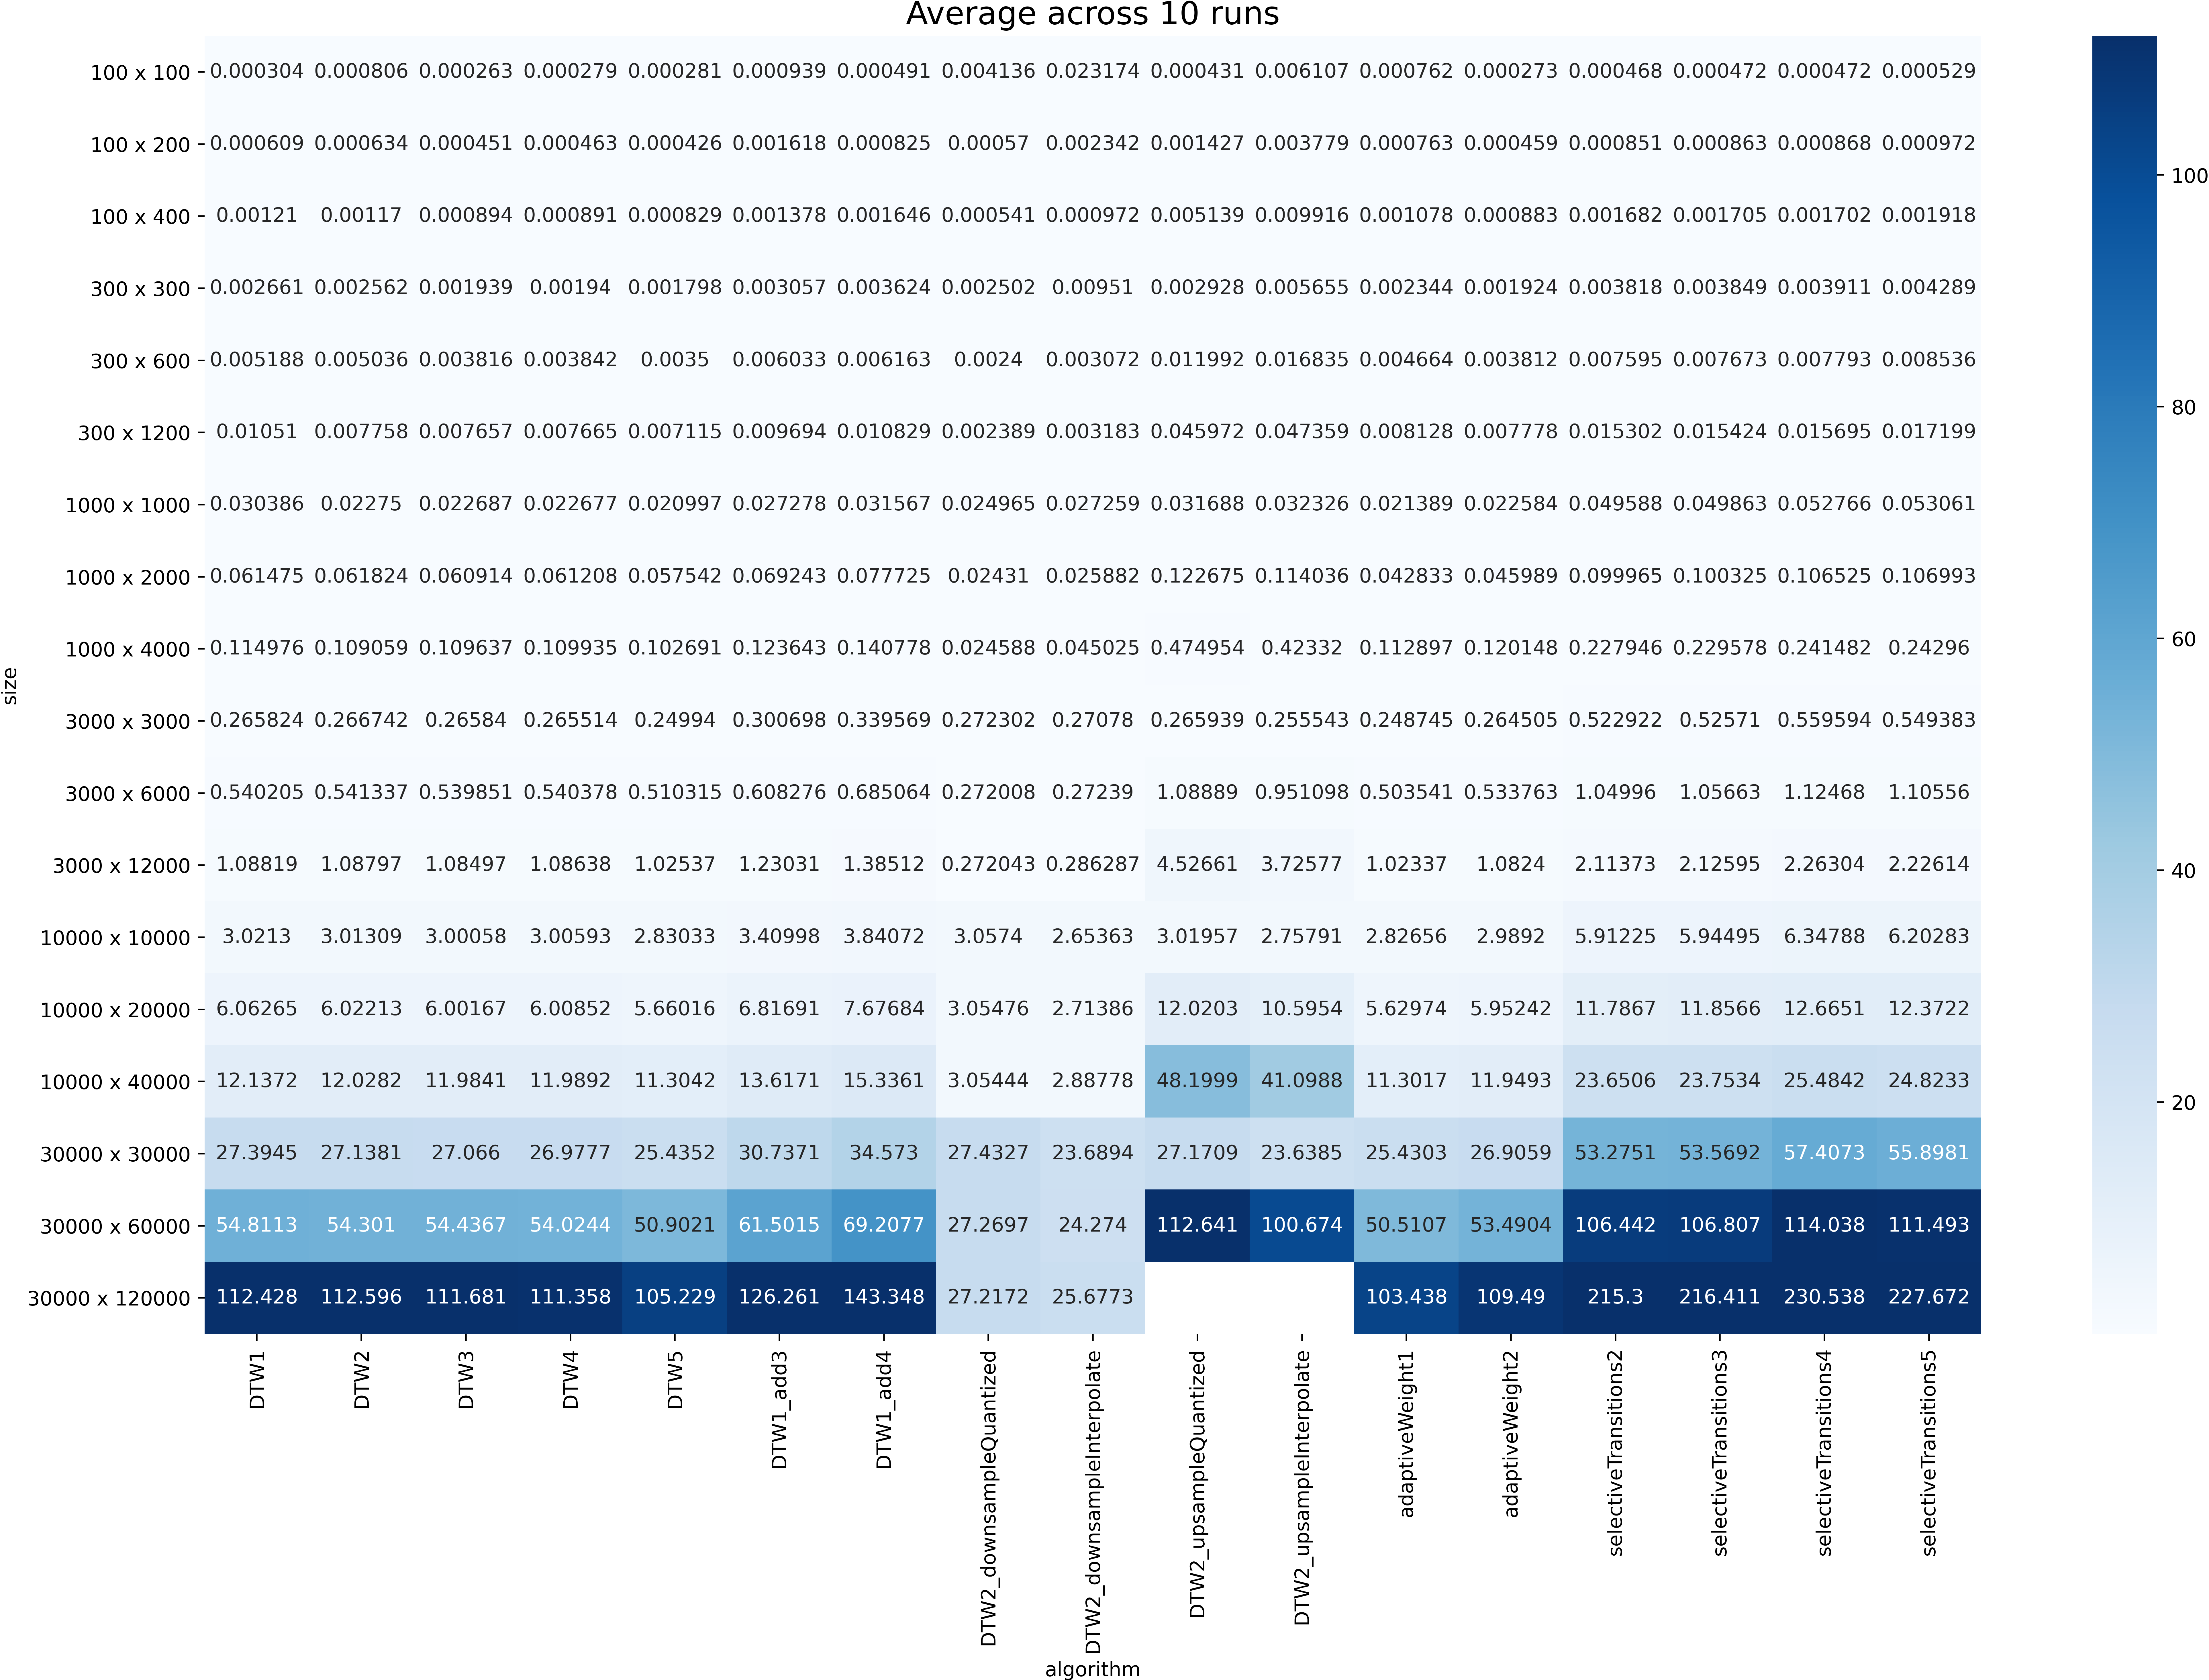

In [53]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['figure.figsize'] = [20, 12]
mpl.rcParams['savefig.pad_inches'] = 0

ax = sns.heatmap(mean, annot=True, cmap="Blues", vmin=0.0001, vmax=112, fmt='g')
ax.set_title("Average across 10 runs", fontsize=16)

In [43]:
df =  pd.read_csv('run_time.csv')
for i in range(3,df.shape[1]):
    df.iloc[:,i] = df.iloc[:,i].apply(lambda x: float(x))
df['total'] = df["adjust_sample_adaptive"] + df["compute_cost_matrix"] + df["get_accum_cost_and_steps"] + df["retrieve_path"] + df["adjust_sample"]
df = df.drop(["adjust_sample_adaptive", "compute_cost_matrix", "get_accum_cost_and_steps", "retrieve_path", "adjust_sample"], axis=1)

mean = df.groupby(["algorithm", "N", "M"]).std().reset_index()
mean['size'] =  mean['N'].astype(str) + " x " + mean['M'].astype(str)
mean.drop(["N", "M"], axis = 1, inplace=True)
mean = mean.pivot(index="size", columns="algorithm", values="total")
index = list(mean.index)
index.sort(key = lambda x: int(x.split(" x ")[0]) + int(x.split(" x ")[1]))
mean = mean.reindex(index)
mean = round(mean, 6)
mean = mean[['DTW1', 'DTW2', 'DTW3', 'DTW4', 'DTW5', 'DTW1_add3', 'DTW1_add4', 'DTW2_downsampleQuantized', 'DTW2_downsampleInterpolate', 'DTW2_upsampleQuantized', 'DTW2_upsampleInterpolate', 'adaptiveWeight1', 'adaptiveWeight2', 'selectiveTransitions2','selectiveTransitions3','selectiveTransitions4','selectiveTransitions5']]

Text(0.5, 1.0, 'Standard Deviation across 10 runs')

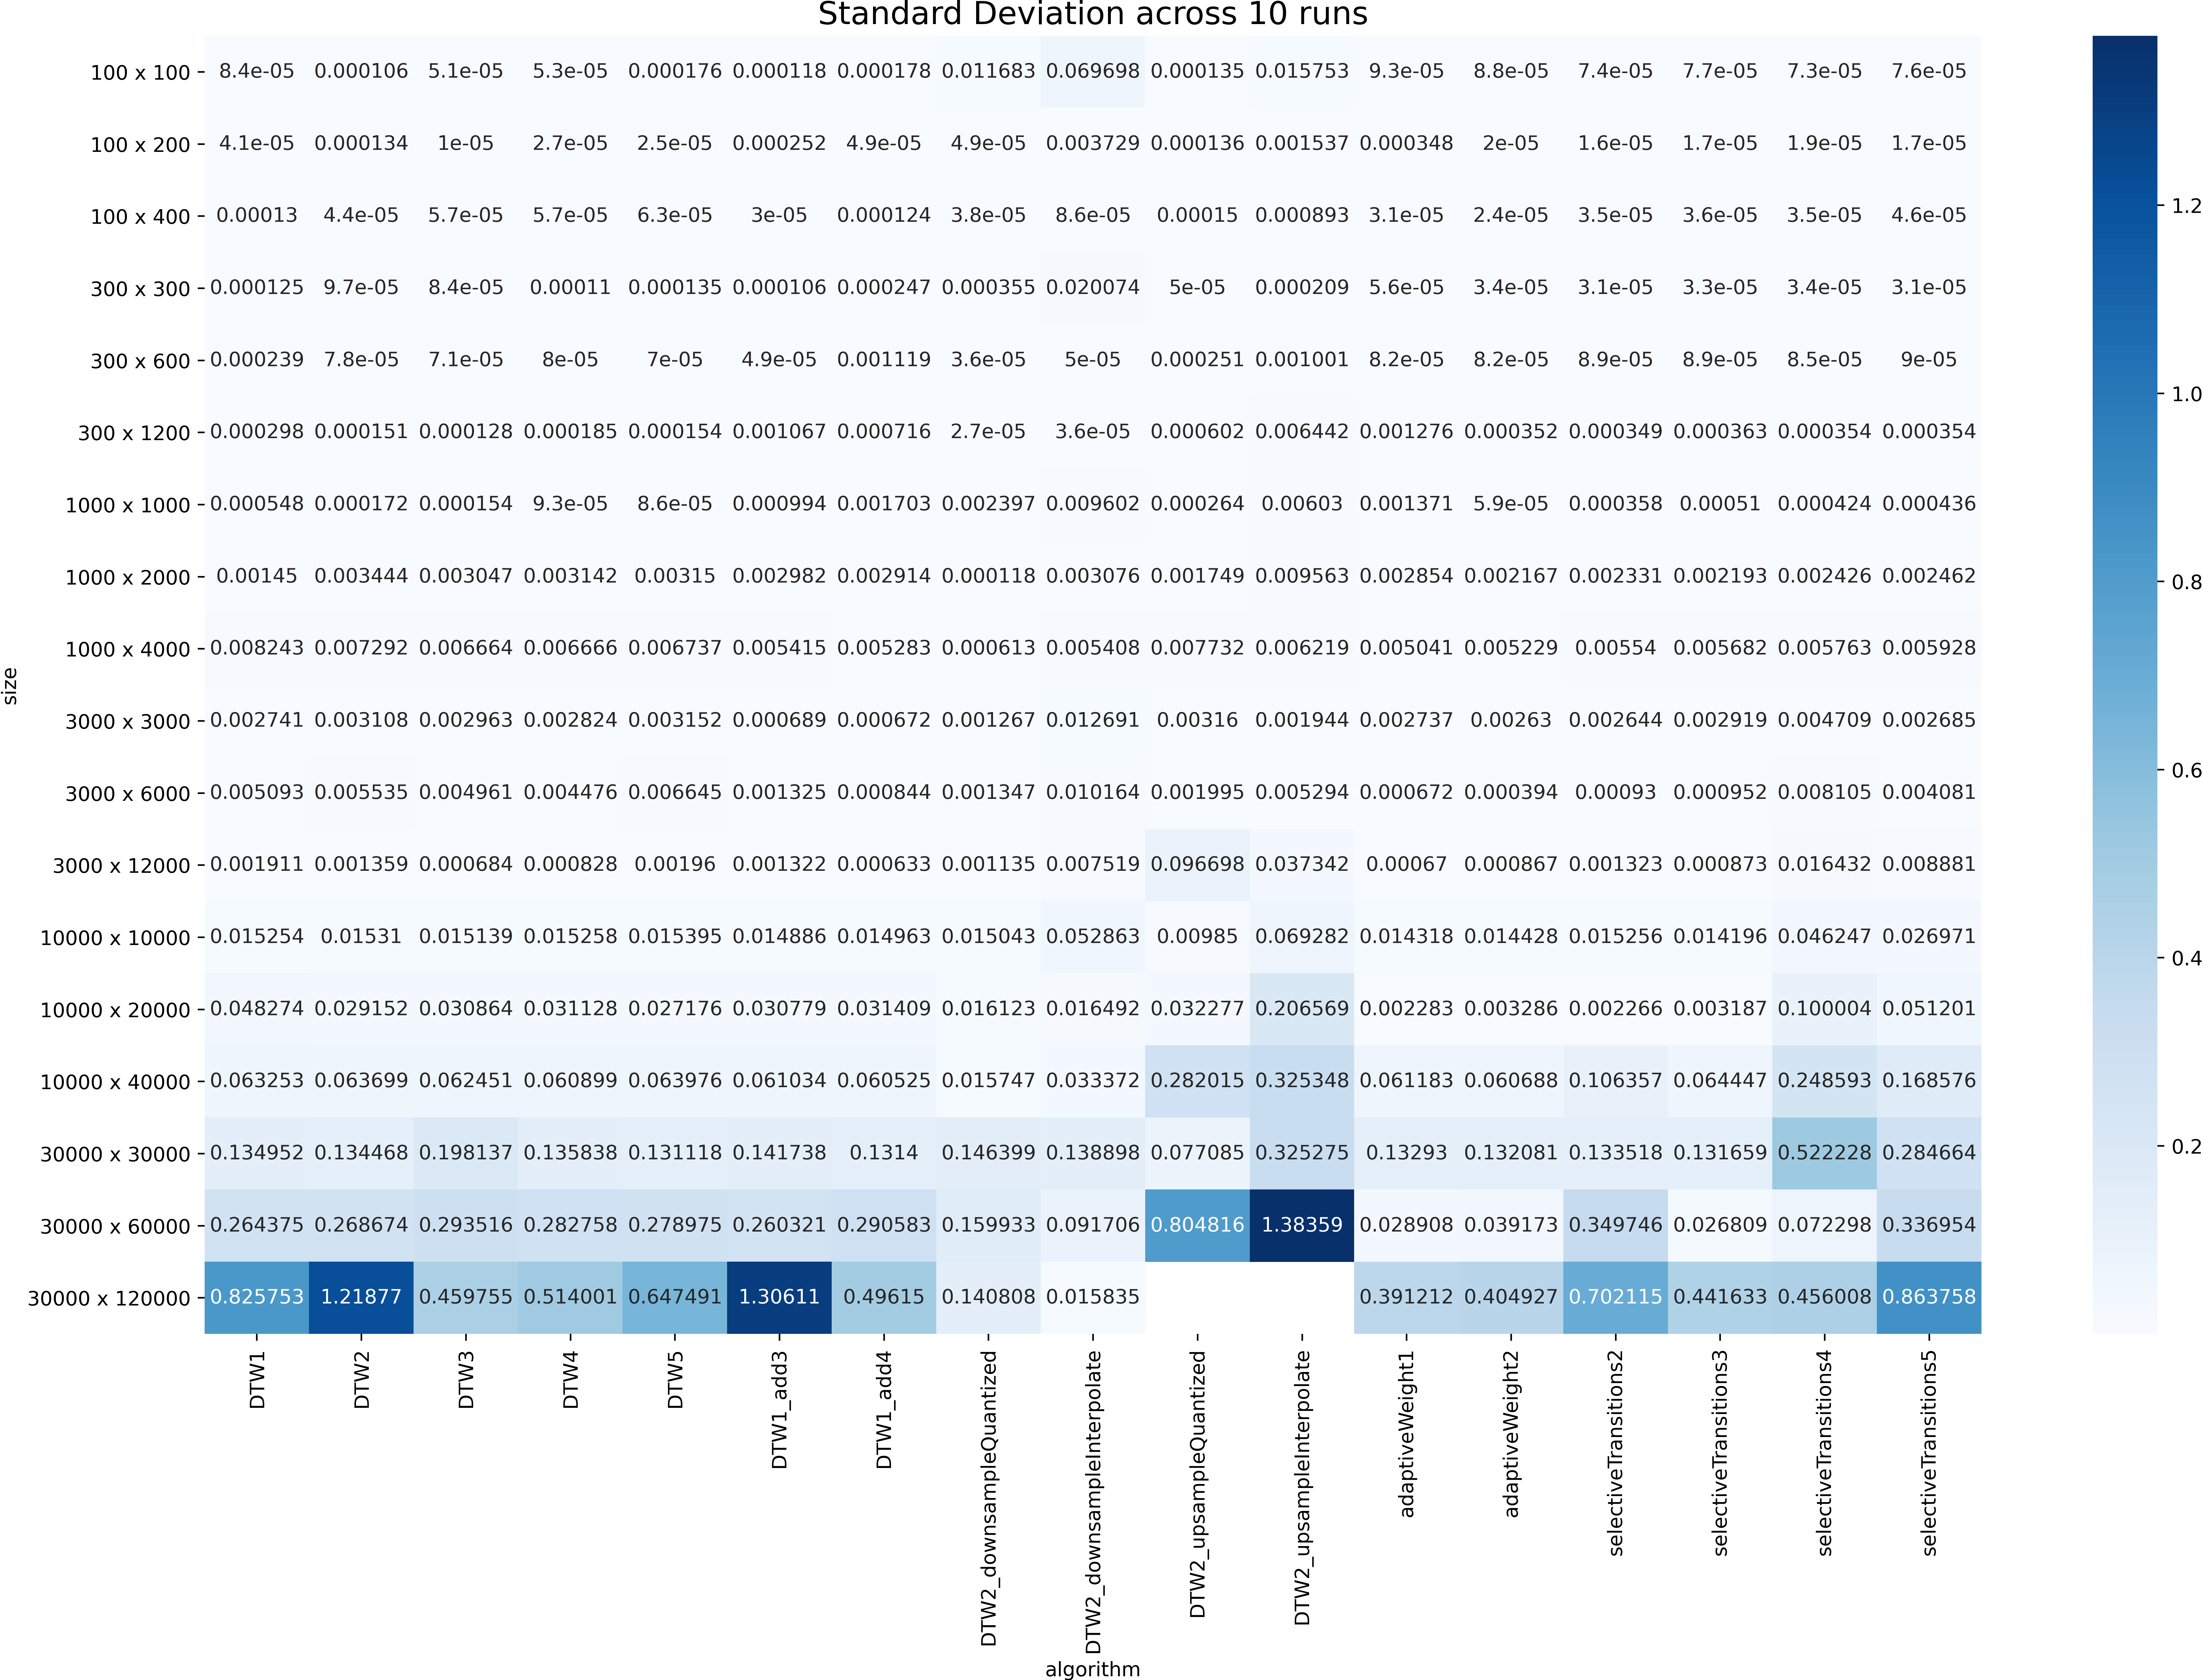

In [48]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['figure.figsize'] = [20, 12]
mpl.rcParams['savefig.pad_inches'] = 0

ax = sns.heatmap(mean, annot=True, cmap="Blues", vmin=1e-5, vmax=1.38, fmt='g')
ax.set_title("Standard Deviation across 10 runs", fontsize=16)